Explore Results of Model

# Number of events
# Number of waveforms
# Total Number of Samples
# F1 Scores

In [12]:
#!/usr/bin/env python3

from itertools import product
from collections import deque

import os
import pandas as pd
import glob
import numpy as np

import datetime
from scipy import signal
import pywt

import pyarrow as pa
import pyarrow.parquet as pq
import json

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, os.path.abspath('../bin/models'))

from nested_xval_utils import *

#NGA SYNTHETIC DATA
##############
#pq_list=[os.path.join(os.path.dirname(os.getcwd()), 'data/feature_sets/',f) for f in os.listdir(os.path.join(os.path.dirname(os.getcwd()), 'data/feature_sets/'))]
pq_list=os.listdir('../data/feature_sets/')
pq_list=[os.path.join('../data/feature_sets/',f) for f in os.listdir('../data/feature_sets/')]
#pd_list=[pd.read_parquet(pq) for pq in pq_list if ".pq" in pq]
meta_list=[read_meta(pq_fs) for pq_fs in pq_list if ".pq" in pq_fs]
meta_df=pd.DataFrame.from_records(meta_list)
meta_df_nga=meta_df

######################
ambient_list= list(meta_df[meta_df.magnitude.isnull()].eq_name.unique())
event_list=meta_df[~meta_df.magnitude.isnull()].sort_values(['magnitude'], ascending=False).groupby("eq_name").count().sort_values(['station'], ascending=False).index.tolist()
full_list=ambient_list+event_list

#convert to rsn
full_list_nga=meta_df[meta_df.eq_name.isin(full_list)].record_number.unique()
event_list_nga=meta_df[meta_df.eq_name.isin(event_list)].record_number.unique()


## JGR GNSS DATA
###############  Generate list of samples by event
#pq_list=[os.path.join(os.path.dirname(os.getcwd()), 'data/feature_set/',f) \
#         for f in  os.listdir(os.path.join(os.path.dirname(os.getcwd()), 'data/feature_set/'))]

pq_list=[os.path.join('../../snivel/data/feature_set/',f) for f in os.listdir('../../snivel/data/feature_set/')]
meta_list=[read_meta(pq_fs) for pq_fs in pq_list if ".pq" in pq_fs]
meta_df=pd.DataFrame.from_records(meta_list)

jgr_test=meta_df[(meta_df.radius_from_event<70) | (meta_df.radius_from_event==np.nan)]
jgr_test=meta_df[(meta_df.radius_from_event<70) | (meta_df['radius_from_event'].isna())]

In [6]:
fs={'feature':['psd_t'], 'stacking':['horizontal'], 'dims':[['H0','H1','UP']], 'augment':[True]}
feature_sets=[dict(zip(fs, v)) for v in product(*fs.values())]

d = {'n_folds':[5],'max_depth': [100], 'n_estimators': [120], 'class_wt':[None, 'balanced'],'wl_thresh':[0]}
hyperp=[dict(zip(d, v)) for v in product(*d.values())]

params=[i | feature_sets[0] for i in hyperp]

In [9]:
X_train_nga, y_train_nga, name_list_nga, times_nga, snr_metric=list_to_featurearrays(full_list_nga, params[0], test=True)

In [14]:
# number of samples
print(len(X_train_nga))

# number of waveforms
print(len(meta_df_nga.record_number.unique()))

# number of events
print(len(meta_df_nga.eq_name.unique()))

422309
2007
217


In [13]:
meta_df_nga.head()

,station,year,eq_name,record_number,magnitude,mechanism,Rjb,Rrup,Vs30,noise_lev
0,"""Del Valle Dam (Toe)""",1980,"""Livermore-01""",212,5.80,strike slip,23.92,24.95,403.37,5
1,"""Parkfield - Vineyard Cany 3W""",2004,"""Parkfield-02_ CA""",4134,6.00,strike slip,4.43,5.21,308.87,50
2,"""Cerro Prieto""",1987,"""Baja California""",585,5.50,strike slip,3.43,4.46,471.53,5
3,"""Parkfield - Vineyard Cany 1W""",2004,"""Parkfield-02_ CA""",4131,6.00,strike slip,1.00,2.75,284.21,35
4,"""Anza Fire Station""",1986,"""N. Palm Springs""",513,6.06,Reverse Oblique,42.17,42.36,360.45,80


In [15]:
import pandas as pd
import glob
import os
import numpy as np
  
# merging the files
#joined_files = os.path.join("results", "station*.csv")
joined_files = "../data/results/nested*.csv"
  
# A list of all joined files is returned
joined_list = glob.glob(joined_files)
  
# Finally, the files are joined
df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)


In [17]:
# F1 Scores as a function of feature extraction
features=['psd_t','psd','time']
for feature in features:
    print(df[(df.feature==feature) & (df.augment==True)].f1.mean())

0.8221643854109175
0.7900616556999166
0.7860200079681087


# Station level detectability as a function of augmentation

In [18]:
import pandas as pd
import glob
import os
import numpy as np
  
# merging the files
#joined_files = os.path.join("results", "station*.csv")
joined_files = "../data/results/station_results*.csv"
  
# A list of all joined files is returned
joined_list = glob.glob(joined_files)
  
# Finally, the files are joined
df_sta = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)

In [23]:
for bool_ in [True, False]:
    tmp=df_sta[(df_sta.augment==bool_) &(df_sta.features=='psd_t')]
    print(len(tmp[tmp.marker=='o'])/len(tmp))

0.8970268310369833
0.8467005076142132


(0.6, 1.0)

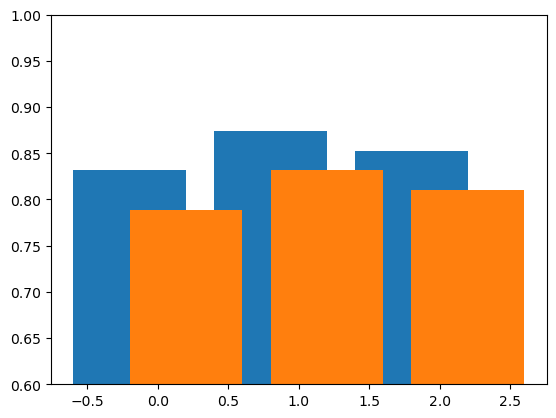

In [6]:
x = np.arange(3)
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
for aug, offs in zip([True,False],[-.2,.2]):
    ax.bar(x+offs,df[(df.feature=='all') & (df.augment==aug)][['precision','recall','f1']].mean())
ax.set_ylim([.6,1])

In [27]:
x

array([0, 1])

In [30]:
df[(df.feature=='all') & (df.augment==aug)][['precision','recall','f1']].mean()

precision    0.800852
recall       0.695360
f1           0.734820
dtype: float64

In [24]:
index=45
#index=13179
ts=pd.read_parquet('../../psuedosyn_gnssvel/data/synth_ts/45_50.pq')

In [26]:
tmp=ts['H0_ts'].iloc[:150]

In [27]:
f, p=signal.periodogram(x=tmp.values, fs=5, nfft=5*30)

In [31]:
(1/f)[1:30]

/tmp/ipykernel_3556/3286532660.py:1: RuntimeWarning: divide by zero encountered in divide
  (1/f)[1:30]


array([30.        , 15.        , 10.        ,  7.5       ,  6.        ,
        5.        ,  4.28571429,  3.75      ,  3.33333333,  3.        ,
        2.72727273,  2.5       ,  2.30769231,  2.14285714,  2.        ,
        1.875     ,  1.76470588,  1.66666667,  1.57894737,  1.5       ,
        1.42857143,  1.36363636,  1.30434783,  1.25      ,  1.2       ,
        1.15384615,  1.11111111,  1.07142857,  1.03448276])